# Part 2 – K-nearest-neighbour classifier

**a) Split the dataset into training, validation and testing sets.**

In [1]:
# Importing the libraries

import pandas as pd
import numpy as np


In [2]:
# Loading the diamonds dataset

diamonds_dataset = pd.read_csv("../data/diamonds.csv")
diamonds_dataset.head()


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [3]:
# Splitting the dataset into training, validation and testing sets

n = len(diamonds_dataset)
splits = [int(0.6 * n), int(0.7 * n)]

training, validation, testing = np.split(
    diamonds_dataset.sample(frac=1, random_state=100), splits
)

training.shape, validation.shape, testing.shape


((32364, 10), (5394, 10), (16182, 10))

**b) Implement the scikit-learn estimator API for a K-nearest-neighbour classifier. Your estimator API will implement the Euclidean distance. Your estimator will accept the following parameters:**
- k: This parameter controls the number of neighbours to consider. Set the default value
to 5
- distances: This parameter allows the user to precalculate distances for the datapoints, overriding the default (Euclidean) distance that you have implemented. The values passed to this parameter can be either a matrix of pairwise similarities, or the string "euclidean". If the string "euclidean" is received, the estimator will calculate the distances; otherwise, no distances will be calculated, and the matrix that is being passed as a parameter will be used. Note that if the size of the matrix is not compatible with the number datapoints, your estimator must raise an Exception.

In [81]:
# Implementing the function to calculate the euclidean distance
# with the scikit-learn estimator API for a K-nearest-neighbour
# classifier


from sklearn.base import BaseEstimator


class KNNClassifier(BaseEstimator):
    def __init__(self, k=5, distances="euclidean"):
        self.k = k
        self.distances = distances

    def fit(self, X, y):
        self.X = X
        self.y = y
        return self

    def predict(self, X):
        predictions = None

        if self.distances == "euclidean":
            n_samples, n_features = X.shape
            predictions = np.empty(n_samples, dtype=object)

            for i in range(n_samples):
                distances = np.sqrt(np.sum(np.square(self.X - X[i, :]), axis=1))
                k_nearest_neighbours = np.argsort(distances)[: self.k]

                values, counts = np.unique(
                    self.y[k_nearest_neighbours], return_counts=True
                )

                predictions[i] = values[np.argmax(counts)]
        else:
            raise Exception("Unimplemented")

        return predictions


**c) Using your implementation of KNN, select the set of 3 numerical features that predict the "cut" variable with the best ACCURACY score on the validation set for each of the following different values of K: 2, 5, 10, and 15**

In [6]:
# Creating a dataset with all the accuracy scores

from sklearn.metrics import accuracy_score
import pandas as pd

ks = [2, 5, 10, 15]

columns = ["carat", "depth", "table", "price", "x", "y", "z"]
columns_permutations = []

for i in range(len(columns) - 2):
    for j in range(i + 1, len(columns) - 1):
        for k in range(j + 1, len(columns)):
            columns_permutations.append([columns[i], columns[j], columns[k]])

n = 400

accuracy_scores = pd.DataFrame(columns=["k", "features", "accuracy"])

for k in ks:
    classifier = KNNClassifier(k=k)

    for permutation in columns_permutations:
        train_features = training[permutation].values
        train_cut = training["cut"].values

        validation_features = validation[permutation].values[:n]
        validation_cut = validation["cut"].values[:n]

        classifier.fit(train_features, train_cut)
        predictions = classifier.predict(validation_features)

        accuracy = accuracy_score(validation_cut, predictions)

        features = ", ".join(permutation)

        result = pd.DataFrame(
            {"k": [k], "features": [features], "accuracy": [accuracy]}
        )

        accuracy_scores = pd.concat(
            [accuracy_scores, result], ignore_index=True, axis=0
        )

        print(f"k={k}, features='{features}', accuracy={accuracy}")


k=2, features='carat, depth, table', accuracy=0.645
k=2, features='carat, depth, price', accuracy=0.46
k=2, features='carat, depth, x', accuracy=0.4875
k=2, features='carat, depth, y', accuracy=0.5325
k=2, features='carat, depth, z', accuracy=0.495
k=2, features='carat, table, price', accuracy=0.4925
k=2, features='carat, table, x', accuracy=0.5925
k=2, features='carat, table, y', accuracy=0.5725
k=2, features='carat, table, z', accuracy=0.58
k=2, features='carat, price, x', accuracy=0.38
k=2, features='carat, price, y', accuracy=0.3775
k=2, features='carat, price, z', accuracy=0.3775
k=2, features='carat, x, y', accuracy=0.5225
k=2, features='carat, x, z', accuracy=0.4975
k=2, features='carat, y, z', accuracy=0.5025
k=2, features='depth, table, price', accuracy=0.585
k=2, features='depth, table, x', accuracy=0.6325
k=2, features='depth, table, y', accuracy=0.6375
k=2, features='depth, table, z', accuracy=0.6525
k=2, features='depth, price, x', accuracy=0.4625
k=2, features='depth, pri

In [50]:
# Selecting and printing the best accuracy scores for each k

best_accuracy_scores = accuracy_scores.groupby("k").max()
best_accuracy_scores.head()

,features,accuracy
k,,
2,"x, y, z",0.655
5,"x, y, z",0.705
10,"x, y, z",0.715
15,"x, y, z",0.710


**d) Make a barplot of the accuracy on the validation set obtained by each set of 3 numerical features for the different values of k, highlighting in a different color the bars with the best accuracy. The figure should look like Figure 3 (with different values, as in the Figure I randomized the data and feature names to avoid giving away the solution)**

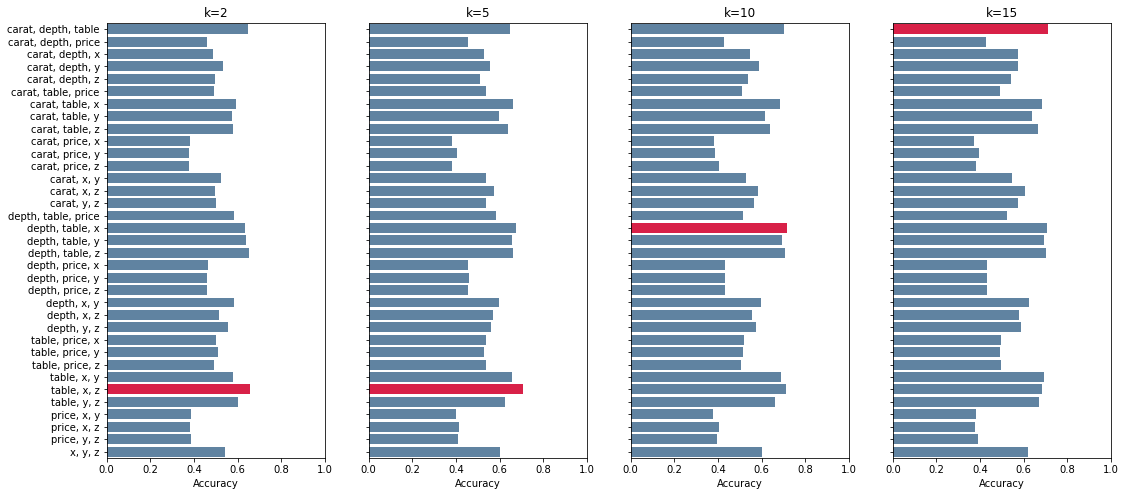

In [71]:
# Plotting the accuracy scores for each k and set of columns

import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 4, figsize=(18, 8), sharey=True)

for i, k in enumerate(ks):
    ax = axs[i]
    ax.set_title(f"k={k}")

    data = accuracy_scores[accuracy_scores["k"] == k]

    sns.barplot(
        data = data,
        x = "accuracy",
        y = "features",
        ax = ax,
        color = "#5584AC",
        order = data["features"].values,
    )

    best_acc = best_accuracy_scores.loc[k, "accuracy"]
    best_acc_index = data["accuracy"].values.argmax()
    ax.patches[best_acc_index].set_facecolor("#D82148")

    ax.set(xlim=(0, 1), xlabel="Accuracy", ylabel="")
